# Importing ONNX models to MXNet

We'll show how you can use ONNX-MXNet to import ONNX models into MXNet, and use the imported model for inference, benefiting from MXNet's optimized execution engine.
	
## Step 1: Installations
	
First, install ONNX, following instructions on the ONNX repo. Also, make sure MXNet(version >=1.2.0) is installed.

Install Pillow, Python Imaging Library, so we can load and pre-process the input image: 

```
$ pip install Pillow
```
	
## Step 2: Prepare an ONNX model to import

In this example, we will demonstrate importing a Super Resolution model, designed to increase spatial resolution of images. The model was built and trained with PyTorch, and exported into ONNX using PyTorch's ONNX export API. More details about the model design are available in PyTorch's example.
	
Download the Super Resolution ONNX model to your working directory. At the same time download the input image we're going to be using for test inference:

```
$ wget https://s3.amazonaws.com/onnx-mxnet/examples/super_resolution.onnx
$ wget https://s3.amazonaws.com/onnx-mxnet/examples/super_res_input.jpg
```

## Step 3: Import the ONNX model into MXNet

Now that we have an ONNX model file ready, let's import it into MXNet using ONNX-MXNet's import API.

In [12]:
import mxnet.contrib.onnx as onnx_mxnet
sym, arg_params, aux_params = onnx_mxnet.import_model('super_resolution.onnx')

This created two instances in the Python runtime: sym - the model's symbolic graph, and params - the model's weights. Importing the ONNX model is now done, and we have a standard MXNet model.
	
## Step 4: Prepare input for inference

Next, we will prepare an input image for inference. The steps below downloads an example image, resizes it to the model's expected input shape, and finally converts it into a numpy array.

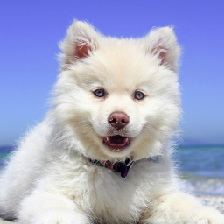

In [13]:
import numpy as np
import mxnet as mx
from PIL import Image
img = Image.open('super_res_input.jpg').resize((224, 224))
display(img) # show the image
img_ycbcr = img.convert("YCbCr")
img_y, img_cb, img_cr = img_ycbcr.split()
x = mx.nd.array(np.array(img_y)[np.newaxis, np.newaxis, :, :])

## Step 5: Create the MXNet Module

We'll be using MXNet's Module API to create the module, bind it and assign the loaded weights.
Note that the ONNX-MXNet’s import API assigns the input layer the name 'input_0', which we are using when initializing and binding the module.

In [14]:
mod = mx.mod.Module(symbol=sym, data_names=['1'], label_names=None)
mod.bind(for_training=False, data_shapes=[('1',x.shape)])
mod.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True, allow_extra=True)

## Step 6: Run inference
Now that we have an MXNet Module loaded, bound and with trained weights, we're ready to run inference. We'll prepare a single input batch, and feed forward through the network:

In [15]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])
mod.forward(Batch([x]))
output = mod.get_outputs()[0][0][0]

## Step 7: Examine the results
Now let's examine the results we received running inference on the Super Resolution image:

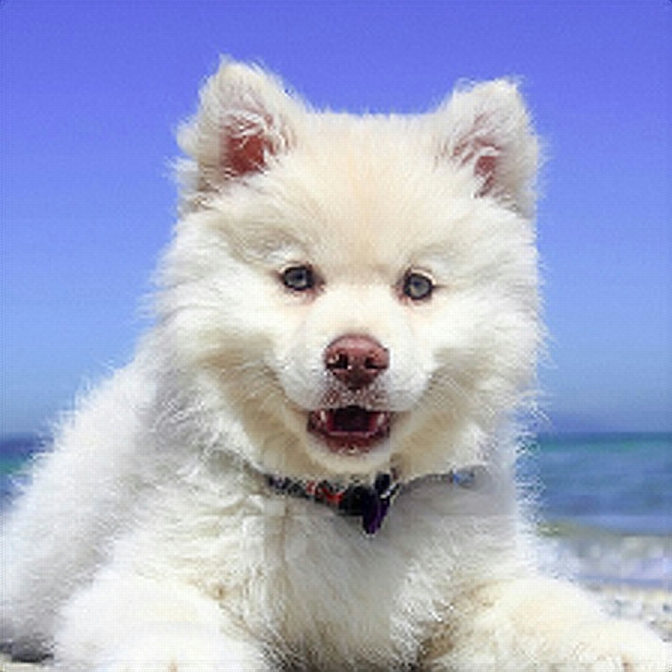

In [16]:
img_out_y = Image.fromarray(np.uint8((output.asnumpy().clip(0, 255)), mode='L'))
result_img = Image.merge("YCbCr", [
        	img_out_y,
        	img_cb.resize(img_out_y.size, Image.BICUBIC),
        	img_cr.resize(img_out_y.size, Image.BICUBIC)
]).convert("RGB")
display(result_img)
result_img.save("super_res_output.jpg")

Here’s the input image and the resulting output image. As you can see, the model was able to increase the image spatial resolution from 256 by 256 to 672 by 672.